# Infancias vs vegetación

Density of population of the ages 0-5 (early childhood) and vegetation

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


2023-05-18 19:34:46 Configured OSMnx 1.1.2
2023-05-18 19:34:46 HTTP response caching is on


## Download data

### Municipality boundaries

In [3]:
mun_schema = 'metropolis'
mun_folder = 'metro_gdf'

city = 'Monterrey'

query = f"SELECT * FROM {mun_schema}.{mun_folder} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

(18, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,19001,19,001,Abasolo,"POLYGON ((-100.39267 25.98715, -100.39224 25.9...",Monterrey
1,19006,19,006,Apodaca,"POLYGON ((-100.24794 25.86462, -100.24672 25.8...",Monterrey


### NDVI Data

In [4]:
ndvi_schema = 'raster_analysis'
ndvi_folder = 'ndvi_analysis_hex'

res = 8

query = f"SELECT * FROM {ndvi_schema}.{ndvi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(1545, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,8848a20723fffff,"POLYGON ((-100.30902 25.68176, -100.30427 25.6...",8,0.051105,0.029174,0.052592,0.086906,-0.000158,0.087065,-0.000529,Monterrey
1,8848a2005bfffff,"POLYGON ((-100.24868 25.61508, -100.25385 25.6...",8,0.437738,0.185475,0.460157,0.685148,0.082410,0.602738,-0.004488,Monterrey


### 2020 Census data 

In [5]:
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())

In [6]:
cvegeo_list

['19001',
 '19006',
 '19009',
 '19010',
 '19012',
 '19018',
 '19019',
 '19021',
 '19025',
 '19026',
 '19031',
 '19039',
 '19041',
 '19045',
 '19046',
 '19047',
 '19048',
 '19049']

In [7]:
# donwload hexagons with pop data
hex_pop = gpd.GeoDataFrame()
hex_folder = 'hex_bins_pop_2020'
hex_schema = 'censo'


# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_pop = pd.concat([hex_pop, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_pop.shape)
hex_pop.head(2)

(1545, 225)


,geometry,hex_id_8,CVEGEO,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic
0,"POLYGON ((-100.38026 25.93877, -100.38069 25.9...",8848a23881fffff,19001,255.11478,126.77050,123.34427,14.639343,6.540983,8.098361,235.47542,...,14.639343,61.672134,28.967210,34.262295,11.213116,9.032786,1.557377,4.360656,33.950817,0.934426
1,"POLYGON ((-100.38588 25.94625, -100.38631 25.9...",8848a23883fffff,19001,487.42150,252.72832,234.69318,26.695550,11.456676,12.238875,460.44028,...,22.552692,123.489456,58.348946,63.208430,20.660423,17.222483,2.210773,7.018735,67.737690,0.983607


## Data treatment

### Early childhood and % Calculation

<AxesSubplot:>

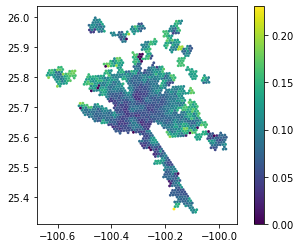

In [8]:
hex_pop['p_infancia'] = hex_pop['p_0a2'] + hex_pop['p_3a5']
hex_pop['pct_infancia'] = hex_pop['p_infancia'] / hex_pop['pobtot']

hex_pop.plot('pct_infancia', legend=True)


### Range / Categories 

In [9]:
hex_pop['pct_inf_rango'] = np.nan
hex_pop.loc[hex_pop.pct_infancia>=0.14 , 'pct_inf_rango'] = '+14%'
hex_pop.loc[(hex_pop.pct_infancia>=0.12 )&
             (hex_pop.pct_infancia<0.14), 'pct_inf_rango'] = '14% - 12%'
hex_pop.loc[(hex_pop.pct_infancia>=0.10)&
             (hex_pop.pct_infancia<0.12), 'pct_inf_rango'] = '12% - 10%'
hex_pop.loc[(hex_pop.pct_infancia>=0.08)&
             (hex_pop.pct_infancia<0.1), 'pct_inf_rango'] = '10% - 8%'
hex_pop.loc[(hex_pop.pct_infancia>=0.06)&
             (hex_pop.pct_infancia<0.08), 'pct_inf_rango'] = '8% - 6%'
hex_pop.loc[(hex_pop.pct_infancia>=0.03)&
             (hex_pop.pct_infancia<0.06), 'pct_inf_rango'] = '6% - 3%'
hex_pop.loc[(hex_pop.pct_infancia<0.03), 'pct_inf_rango'] = '3% - 0%'

#Definir orden y convertir pct_inf_rango en categoría ordenada
categories = ['3% - 0%', '6% - 3%', '8% - 6%', '10% - 8%', '12% - 10%', '14% - 12%', '+14%']
hex_pop['pct_inf_rango'] = pd.Categorical(hex_pop['pct_inf_rango'], categories=categories, ordered=True)

In [10]:
ndvi_gdf['ndvi_median_rango'] = np.nan
ndvi_gdf.loc[ndvi_gdf.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.4 )&
             (ndvi_gdf.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.2)&
             (ndvi_gdf.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.1)&
             (ndvi_gdf.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'


#Definir orden y convertir pct_inf_rango en categoría ordenada
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_gdf['ndvi_median_rango'] = pd.Categorical(ndvi_gdf['ndvi_median_rango'], categories=categories, ordered=True)


### Plot data visualization

NameError: name 'hex_pop' is not defined

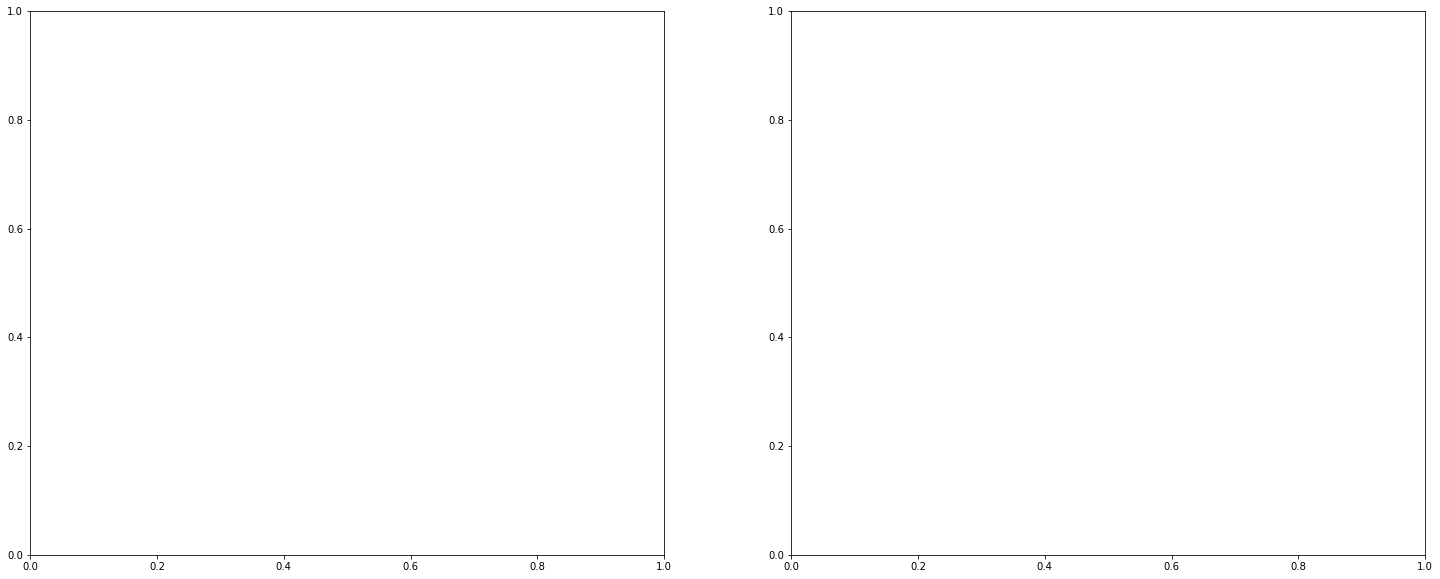

In [3]:
# Plotear gráficos
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
hex_pop.plot('pct_inf_rango', 'BuPu', ax=ax[0], legend=True)
ndvi_gdf.plot('ndvi_median_rango','YlGn', ax=ax[1], legend=True)

ax[0].set_title('Porcentaje de población en edad de 0 - 5 años')
ax[1].set_title('Índice de vegetación')

# Guardar gráficos
plt.savefig("../../../output/figures/ndvi_infancia/ndvi_mty_ca.jpg")

